In [255]:
import numpy as np
import random
import time
import pandas as pd
from matplotlib import pyplot as plt
from numpy import linalg as LA
import pickle as pk
import statsmodels.api as sm

In [7]:
def load_data_np(filename):
    return np.genfromtxt(filename, delimiter=',')
def load_data_pd(filename):
    return pd.read_csv(filename,delimiter=',')

In [3]:
filename=r".\data\NYPD_Motor_Vehicle_Collisions.csv"


In [21]:
types_dict={
"DATE":"object",
"TIME":"object",
"BOROUGH":"object",
"ZIP CODE":"object",
"LATITUDE":"float64",
"LONGITUDE":"float64",
"LOCATION":"object",
"ON STREET NAME":"object",
"CROSS STREET NAME":"object",
"OFF STREET NAME":"object",
"NUMBER OF PERSONS INJURED":"float64",
"NUMBER OF PERSONS KILLED":"float64",
"NUMBER OF PEDESTRIANS INJURED":"float64",
"NUMBER OF PEDESTRIANS KILLED":"float64",
"NUMBER OF CYCLIST INJURED":"float64",
"NUMBER OF CYCLIST KILLED":"float64",
"NUMBER OF MOTORIST INJURED":"float64",
"NUMBER OF MOTORIST KILLED":"float64",
"CONTRIBUTING FACTOR VEHICLE 1":"object",
"CONTRIBUTING FACTOR VEHICLE 2":"object",
"CONTRIBUTING FACTOR VEHICLE 3":"object",
"CONTRIBUTING FACTOR VEHICLE 4":"object",
"CONTRIBUTING FACTOR VEHICLE 5":"object",
"UNIQUE KEY":"int64",
"VEHICLE TYPE CODE 1":"object",
"VEHICLE TYPE CODE 2":"object",
"VEHICLE TYPE CODE 3":"object",
"VEHICLE TYPE CODE 4":"object",
"VEHICLE TYPE CODE 5":"object"
}

In [53]:
df.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2019-04-30,0:00,BROOKLYN,11222,40.727184,-73.950700,"(40.727184, -73.9507)",NaN,NaN,236 ECKFORD STREET,...,Unspecified,NaN,NaN,NaN,4123208,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,2019-04-30,0:00,MANHATTAN,10075,40.776318,-73.962135,"(40.776318, -73.962135)",EAST 79 STREET,MADISON AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4123128,Station Wagon/Sport Utility Vehicle,Ambulance,NaN,NaN,NaN
2,2019-04-30,0:00,QUEENS,11354,40.763283,-73.830710,"(40.763283, -73.83071)",NaN,NaN,137-17 NORTHERN BOULEVARD,...,Unspecified,NaN,NaN,NaN,4124069,Sedan,NaN,NaN,NaN,NaN
3,2019-04-30,0:00,QUEENS,11412,40.705240,-73.775080,"(40.70524, -73.77508)",LIBERTY AVENUE,DUNKIRK STREET,NaN,...,Unspecified,NaN,NaN,NaN,4123202,COMMU,Sedan,NaN,NaN,NaN
4,2019-04-30,0:00,NaN,NaN,40.593525,-73.996280,"(40.593525, -73.99628)",BELT PARKWAY,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4123344,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


In [63]:
nypd_df_raw=pd.read_csv(filename,delimiter=',',dtype=types_dict)

FIltering out the entries after Dec 31,2018

In [65]:
nypd_df_raw['DATE']=pd.to_datetime(nypd_df_raw['DATE'], format="%m/%d/%Y")

In [80]:
less_than_2019=nypd_df_raw['DATE']<='2018-12-31'


In [83]:
nypd_df=nypd_df_raw[less_than_2019]

#### What is the total number of persons injured in the dataset (up to December 31, 2018?)

In [84]:
print(int(nypd_df[['NUMBER OF PERSONS INJURED']].sum()[0]))

368034


#### What proportion of collisions in 2016 resulted in injury or death of a cyclist?

In [71]:
nypd_df[['NUMBER OF CYCLIST INJURED']].sum()+nypd_df[['NUMBER OF CYCLIST KILLED']].sum()

In [89]:
is_2016=(nypd_df['DATE']<='2016-12-31') & (nypd_df['DATE']>='2016-01-01')

In [112]:
cyclist_causalties_2016=nypd_df[is_2016][['NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED']].sum().sum()
total_collisions_2016=nypd_df[is_2016][['UNIQUE KEY']].count()[0]

In [115]:
print(str(cyclist_causalties_2016/total_collisions_2016))

0.02186372597231349


0.2065434511

#### What proportion of all collisions in 2016 occured in Brooklyn? Only consider entries with a non-null value for BOROUGH.

In [124]:
is_Brooklyn=(nypd_df[is_2016]['BOROUGH']=='BROOKLYN')

In [126]:
total_collisions_2016_brooklyn=nypd_df[is_2016][is_Brooklyn].count()[0]

In [127]:
print(str(total_collisions_2016_brooklyn/total_collisions_2016))

0.20654345110907057


#### For each borough, compute the number of accidents per capita involving alcohol in 2017. Report the highest rate among the 5 boroughs. Use populations as given by https://en.wikipedia.org/wiki/Demographics_of_New_York_City.

In [159]:
is_2017=(nypd_df['DATE']<='2017-12-31') & (nypd_df['DATE']>='2017-01-01')
invloves_alcohol_2017=(nypd_df[is_2017]['CONTRIBUTING FACTOR VEHICLE 1']=="Alcohol Involvement") | (nypd_df[is_2017]['CONTRIBUTING FACTOR VEHICLE 2']=="Alcohol Involvement") | (nypd_df[is_2017]['CONTRIBUTING FACTOR VEHICLE 3']=="Alcohol Involvement") | (nypd_df[is_2017]['CONTRIBUTING FACTOR VEHICLE 4']=="Alcohol Involvement") | (nypd_df[is_2017]['CONTRIBUTING FACTOR VEHICLE 5']=="Alcohol Involvement")

#### Polulation of 5 Boroughs
- The Bronx: 1471160
- Brooklyn: 2648771
- Manhattan: 1664727
- Queens: 2358582
- Staten Island: 479458


In [176]:
accidents_per_capita_2017=nypd_df[is_2017][invloves_alcohol_2017][['UNIQUE KEY','BOROUGH']].groupby('BOROUGH').count().reset_index()
accidents_per_capita_2017['POPULATION']=[1471160,2648771,1664727,2358582,479458]
accidents_per_capita_2017=accidents_per_capita_2017.rename(index=str,columns={'UNIQUE KEY':'ACCIDENTS'})
accidents_per_capita_2017['PER CAPITA']=accidents_per_capita_2017['ACCIDENTS']/accidents_per_capita_2017['POPULATION']

In [177]:
accidents_per_capita_2017

,BOROUGH,ACCIDENTS,POPULATION,PER CAPITA
0,BRONX,274,1471160,0.000186
1,BROOKLYN,602,2648771,0.000227
2,MANHATTAN,259,1664727,0.000156
3,QUEENS,512,2358582,0.000217
4,STATEN ISLAND,100,479458,0.000209


In [184]:
accidents_per_capita_2017[['PER CAPITA']].max() # Brooklyn

PER CAPITA    0.000227
dtype: float64

#### Obtain the number of vehicles involved in each collision in 2016. Group the collisions by zip code and compute the sum of all vehicles involved in collisions in each zip code, then report the maximum of these values.

In [298]:
#zip_code_not_null=nypd_df[is_2016][['ZIP CODE']].notnull()==True
nypd_df['NUMBER OF VEHICLES INVOLVED']=nypd_df[['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2',
                  'VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']].count(axis=1)


C:\Users\ajink\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [303]:
COLLISIONS_BY_ZIP=nypd_df[is_2016][['ZIP CODE','NUMBER OF VEHICLES INVOLVED']].groupby('ZIP CODE').sum().reset_index()
MAX_COLLISIONS_BY_ZIP=COLLISIONS_BY_ZIP[['NUMBER OF VEHICLES INVOLVED']].max()[0]

In [304]:
COLLISIONS_BY_ZIP[COLLISIONS_BY_ZIP['NUMBER OF VEHICLES INVOLVED']==MAX_COLLISIONS_BY_ZIP]

,ZIP CODE,NUMBER OF VEHICLES INVOLVED
127,11207,5703


#### Consider the total number of collisions each year from 2013-2018. Is there an apparent trend? Fit a linear regression for the number of collisions per year and report its slope.

In [224]:
is_in_2013_and_2018=(nypd_df['DATE']<='2018-12-31') & (nypd_df['DATE']>='2013-01-01')

In [230]:
nypd_df1=nypd_df[is_in_2013_and_2018][['DATE','UNIQUE KEY']]

In [276]:
nypd_df1['YEAR']=nypd_df1['DATE'].dt.year
nypd_df1['YEAR']=pd.to_numeric(nypd_df1.YEAR)

In [277]:
collisions_per_year_df=nypd_df1.reset_index().drop(columns=['index','DATE']).groupby('YEAR').count().rename(index=str,columns={'UNIQUE KEY':'COLLISIONS'}).reset_index()

In [281]:
collisions_per_year_df['YEAR'].astype(int).values


array([2013, 2014, 2015, 2016, 2017, 2018])

SLOPE =109.13396510524007


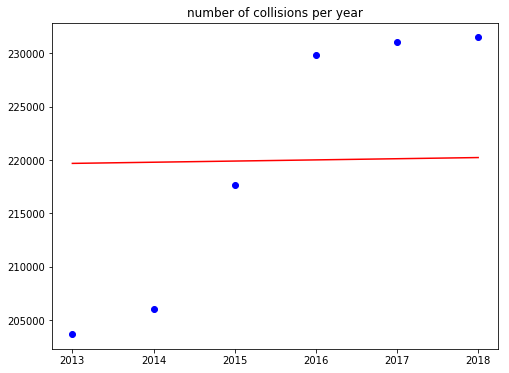

In [294]:
x = np.array(collisions_per_year_df['YEAR'].astype(int).values)
#x = x-min(x)
y = np.array(collisions_per_year_df['COLLISIONS'].astype(int).values)
#y=y-min(y)
results = sm.OLS(y, x).fit()
slope=results.params[0]

plt.figure(figsize=(8,6))
# Plot a line
plt.plot(x, y, 'bo')
y =  slope * x
plt.title('number of collisions per year')
plt.plot(x, y, 'r-')
print('SLOPE ='+str(slope))
plt.show()


#### Do winter driving conditions lead to more multi-car collisions? Compute the rate of multi car collisions as the proportion of the number of collisions involving 3 or more cars to the total number of collisions for each month of 2017. Calculate the chi-square test statistic for testing whether a collision is more likely to involve 3 or more cars in January than in May.

In [10]:
round(109.13396510524007,10)

109.1339651052

In [309]:
nypd_df2=nypd_df[is_2017][['UNIQUE KEY','DATE','NUMBER OF VEHICLES INVOLVED']]

In [311]:
nypd_df2['MONTH']=nypd_df2['DATE'].dt.month

In [326]:
total_collisions_by_month=nypd_df2.drop(columns=['DATE','NUMBER OF VEHICLES INVOLVED']).groupby('MONTH').count().reset_index().rename(index=str,columns={'UNIQUE KEY':'TOTAL'})

In [325]:
is_multiple=nypd_df2['NUMBER OF VEHICLES INVOLVED']>=3
multiple_collisions_by_month=nypd_df2[is_multiple].drop(columns=['DATE','NUMBER OF VEHICLES INVOLVED']).groupby('MONTH').count().reset_index().rename(index=str,columns={'UNIQUE KEY':'MULTIPLE'})

In [329]:
collisions_by_month=pd.merge(total_collisions_by_month, multiple_collisions_by_month, on='MONTH')
collisions_by_month['RATIO']=collisions_by_month['MULTIPLE']/collisions_by_month['TOTAL']

In [330]:
collisions_by_month

,MONTH,TOTAL,MULTIPLE,RATIO
0,1,17551,6212,0.353940
1,2,15835,1028,0.064919
2,3,19336,919,0.047528
3,4,17829,951,0.053340
4,5,21012,1136,0.054064
5,6,21369,1154,0.054003
6,7,19593,1080,0.055122
7,8,19134,1056,0.055190
8,9,19604,1147,0.058508
9,10,20358,1175,0.057717


In [331]:
is_JanMay=(collisions_by_month['MONTH']==1) | (collisions_by_month['MONTH']==5)

In [339]:
chi_square_actual=collisions_by_month[is_JanMay].drop(columns=['MONTH','RATIO']).astype(int).values

In [350]:
chi_square_actual

array([[17551,  6212],
       [21012,  1136]])

In [366]:
sumR1=sum(chi_square_actual[0])
sumR2=sum(chi_square_actual[1])
sumC1=sum(chi_square_actual[:,0])
sumC2=sum(chi_square_actual[:,1])
sumT=sum(sum(chi_square_actual))
E11=(sumR1*sumC1)/sumT
E12=(sumR1*sumC2)/sumT
E21=(sumR2*sumC1)/sumT
E22=(sumR2*sumC2)/sumT

In [367]:
chi_square_exp=np.array([[E11,E12],[E21,E22]])

In [375]:
chi_square_res=np.sum(np.sum(((chi_square_actual-chi_square_exp)**2)/chi_square_exp))
dof=(sumC1-1)*(2-1)

In [380]:
critical_value=chi_square_res/dof

In [381]:
print('Null Hypothesis: A collision is not likely to involve 3 or more cars in January than in May.')
print('Since chi-square test statistic' + str(critical_value) + ' is more than the 0.05, we reject the null hypothesis')


Null Hypothesis: A collision is not likely to involve 3 or more cars in January than in May.
Since chi-square test statistic0.09763426074799893 is more than the 0.05, we reject the null hypothesis


In [11]:
round(0.09763426074799893,10)

0.0976342607

#### We can use collision locations to estimate the areas of the zip code regions. Represent each as an ellipse with semi-axes given by a single standard deviation of the longitude and latitude. For collisions in 2017, estimate the number of collisions per square kilometer of each zip code region. Considering zipcodes with at least 1000 collisions, report the greatest value for collisions per square kilometer. Note: Some entries may have invalid or incorrect (latitude, longitude) coordinates. Drop any values that are invalid or seem unreasonable for New York City.

In [425]:
areas_df=nypd_df[['ZIP CODE','LATITUDE','LONGITUDE']]
in_ny=(areas_df['LATITUDE']>=40.496704) & (areas_df['LATITUDE']<=40.912204) & \
(areas_df['LONGITUDE']>=-74.256) & (areas_df['LONGITUDE']<=-70.701608)
areas_df=areas_df[in_ny]

In [422]:
PI=np.pi
ONE_DEG_LAT=111.03
ONE_DEG_LON=85.39

In [426]:
areas_df=areas_df.groupby('ZIP CODE').std().reset_index()
areas_df['AREA']=PI*areas_df['LATITUDE']*ONE_DEG_LAT*areas_df['LONGITUDE']*ONE_DEG_LON
areas_df=areas_df.drop(columns=['LATITUDE','LONGITUDE'])

##### NOTES
- Area of Eclipse=pi.a.b
- AT 40 degrees N, One degree of latitude =  111.03 km or  68.99 mi
- AT 40 degrees N, One degree of longitude =  85.39 km or  53.06 mi
    - Reference: http://www.longitudestore.com/how-big-is-one-gps-degree.html
- Range: W -74.256 N 40.912204 E -70.701608 S 40.496704
    - Reference: https://www.google.com/maps

In [429]:
zip_collisions_2017=nypd_df[is_2017][['ZIP CODE','UNIQUE KEY']].groupby('ZIP CODE').count().reset_index()
atleast_1000=zip_collisions_2017['UNIQUE KEY']>=1000
zip_collisions_2017=zip_collisions_2017[atleast_1000]

In [431]:
collisions_per_sqkm=zip_collisions_2017.merge(areas_df, on='ZIP CODE')

In [433]:
collisions_per_sqkm['COLLISIONS PER KM.SQ']=collisions_per_sqkm['UNIQUE KEY']/collisions_per_sqkm['AREA']

In [436]:
collisions_per_sqkm['COLLISIONS PER KM.SQ'].max()

5344.034330772173

In [12]:
round(5344.034330772173,10)

5344.0343307722

A sequence of n numbers is considered valid if the sequence begins with 1, ends with a given number j, and no two adjacent numbers are the same. Sequences may use any integers between 1 and a given number k, inclusive (also 1<=j<=k). Given parameters n, j, and k, count the number of valid sequences. The number of valid sequences may be very large, so express your answer modulo 10^10+7.

In [456]:
def getNumberOfSeq(n,k,j):
    return 1*(k-1)**(n-4)*1*(k-1)*1+1*(k-1)**(n-4)*(k-2)*(k-2)*1

def getNumberOfSeqFast(n,k,j):
    term=(k-1)**(n-4)
    return 1*(k-1)**(n-4)*1*(k-1)*1+1*(k-1)**(n-4)*(k-2)*(k-2)*1

In [22]:
def getNumberOfSeqFast(n,k,j):
    term=1
    modNum=10**10+7
    for i in range(n-4):
        term*=(k-1)
        term=term%modNum
    term*=((k-1)+(k-2)*(k-2))
    return term%modNum

In [26]:
getNumberOfSeqFast(10**7,10**12,829)

5012827300

In [21]:
10**10+7

10000000007